In [34]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

In [35]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,T.Low,T.Close,T.Volume,T.Adjusted,V.Open,V.High,V.Low,V.Close,V.Volume,V.Adjusted
3098,2019-04-25,191.130005,191.220001,189.449997,190.479996,29517500,190.479996,255.000000,259.000000,246.070007,...,30.049999,30.340000,44021300,30.340000,160.520004,161.600006,158.550003,161.020004,8862500.0,161.020004
3099,2019-04-26,190.179993,190.690002,188.589996,190.649994,26359500,190.649994,246.500000,246.679993,231.130005,...,30.280001,30.680000,35191800,30.680000,161.259995,163.029999,160.399994,162.929993,7525400.0,162.929993
3100,2019-04-29,190.649994,191.320007,190.339996,191.020004,21716200,191.020004,235.860001,243.979996,232.169998,...,30.820000,30.879999,31762700,30.879999,163.210007,164.500000,163.100006,164.149994,10003600.0,164.149994
3101,2019-04-30,189.479996,189.850006,188.210007,189.539993,31495300,189.539993,242.059998,244.210007,237.000000,...,30.760000,30.959999,35001300,30.959999,164.979996,165.699997,163.919998,164.429993,6432700.0,164.429993
3102,2019-05-01,190.779999,191.320007,188.800003,188.929993,34797100,188.929993,238.850006,240.000000,231.500000,...,30.780001,30.790001,27047000,30.790001,165.539993,165.740005,162.750000,162.789993,5248100.0,162.789993


In [36]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if 'Open' in i[1]])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 205,
 'BP': 211,
 'BUD': 217,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 223,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 229,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'RYSDX': 199,
 'SBUX': 79,
 'SFIX': 235,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 241,
 'T': 247,
 'TGT': 91,
 'TNX': 193,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 253,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85}

In [37]:
CHOSENTICKER = 'QQQ'

In [38]:
days_lookback = 1
pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).apply(lambda y: y.argmax(), axis=1).fillna("QQQ.Open")

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


In [39]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
pct_df.map(lambda x: inv_map[x])

0        0
1       16
2       37
3       24
4       41
5        4
6       22
7       37
8       22
9        4
10      24
11      15
12      20
13      31
14      37
15       5
16      23
17      40
18      13
19      24
20      16
21      20
22      24
23      22
24      37
25       5
26      23
27      30
28      23
29      16
        ..
3073    12
3074     5
3075    29
3076    10
3077    39
3078    25
3079     1
3080    24
3081    29
3082    24
3083    12
3084    12
3085    34
3086     1
3087     4
3088     1
3089    11
3090    25
3091    25
3092    15
3093    29
3094     4
3095    32
3096    10
3097    10
3098     7
3099    20
3100    28
3101    40
3102    40
Length: 3103, dtype: int64

In [42]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig.iloc[:,1:])

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(data_orig.iloc[:,1:])
# data_mat = scaler.transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)

In [43]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [44]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [45]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = to_categorical(pct_df.map(lambda x: inv_map[x]))[:int(row)]
x_test = result[int(row):, :]
y_test = to_categorical(pct_df.map(lambda x: inv_map[x]))[int(row):]

[x_train, y_train, x_test, y_test]

[array([[[6.01738770e-01, 6.01688787e-01, 6.01638303e-01, ...,
          7.47579301e-01, 2.07261256e-03, 7.43167244e-01],
         [7.07466977e-01, 7.07431060e-01, 7.07394774e-01, ...,
          7.11821598e-01, 1.29765949e-03, 7.06550288e-01],
         [7.26521936e-01, 7.26479596e-01, 7.26436889e-01, ...,
          7.02021199e-01, 1.08648737e-03, 6.96627846e-01],
         ...,
         [6.14136257e-01, 6.14228098e-01, 6.14320914e-01, ...,
          7.96170431e-01, 3.10642154e-03, 7.91141473e-01],
         [7.65600983e-01, 7.65632598e-01, 7.65664548e-01, ...,
          7.14683512e-01, 1.35145941e-03, 7.08719508e-01],
         [7.34684238e-01, 7.34732291e-01, 7.34780863e-01, ...,
          7.32882437e-01, 1.74304535e-03, 7.27093980e-01]],
 
        [[7.07466977e-01, 7.07431060e-01, 7.07394774e-01, ...,
          7.11821598e-01, 1.29765949e-03, 7.06550288e-01],
         [7.26521936e-01, 7.26479596e-01, 7.26436889e-01, ...,
          7.02021199e-01, 1.08648737e-03, 6.96627846e-01],
       

In [54]:
LAYERS = 250
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=43))
model.add(Activation('softmax'))

start = time.time()
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 258..., units=250)`
  import sys


compilation time :  0.031601905822753906


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=43)`
  app.launch_new_instance()


In [55]:
MODELNAME = 'multiplemodeltest'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [66]:
VALIDATIONSIZE = 0.05
EPOCHS = 50
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 2575 samples, validate on 136 samples
Epoch 1/50
2575/2575 [==============================] - 29s 11ms/step - loss: 3.1980 - val_loss: 5.9617
Epoch 2/50
2575/2575 [==============================] - 28s 11ms/step - loss: 3.1959 - val_loss: 5.7197
Epoch 3/50
2575/2575 [==============================] - 28s 11ms/step - loss: 3.1865 - val_loss: 5.5110
Epoch 4/50
2575/2575 [==============================] - 33s 13ms/step - loss: 3.1824 - val_loss: 5.6741
Epoch 5/50
2575/2575 [==============================] - 30s 12ms/step - loss: 3.1714 - val_loss: 5.1752
Epoch 6/50
2575/2575 [==============================] - 31s 12ms/step - loss: 3.1815 - val_loss: 5.2654
Epoch 7/50
2575/2575 [==============================] - 30s 12ms/step - loss: 3.1595 - val_loss: 5.2366
Epoch 8/50
2575/2575 [==============================] - 30s 12ms/step - loss: 3.1475 - val_loss: 5.7143
Epoch 9/50
2575/2575 [==============================] - 30s 12ms/step - loss: 3.1383 - val_loss: 5.1847
Epoch 10/50
2575/

In [67]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5')

In [68]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))

In [69]:
from collections import defaultdict
dd = defaultdict(list)
for d in range(days):
    for k in sorted(zip(list(ticker_lookup.keys()), best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[d]), key = lambda x: x[1], reverse=True):
        print(d, k[0], k[1])
        dd[k[0]].append(k[1])
dd

0 AMD 0.16701567
0 NFLX 0.1299558
0 TWTR 0.1248204
0 TSLA 0.114004225
0 DATA 0.062003482
0 PANW 0.051693205
0 USO 0.041098736
0 NVDA 0.04099364
0 STX 0.02976437
0 AAPL 0.028509919
0 GLW 0.025476879
0 SLV 0.020812774
0 WDC 0.017838007
0 FB 0.016812777
0 TGT 0.014337061
0 AMZN 0.013923265
0 GOOG 0.011501762
0 MSFT 0.01107517
0 RHT 0.009789699
0 JWN 0.009608439
0 VRSN 0.009483986
0 SQ 0.008383468
0 SBUX 0.005706749
0 PFE 0.0053071417
0 BUD 0.0050142356
0 DIS 0.0041897623
0 RYSDX 0.003924547
0 DUK 0.0028852806
0 GLD 0.0022750788
0 BP 0.0020507574
0 INTC 0.0019332223
0 BABA 0.0018210482
0 WMT 0.0017131516
0 V 0.0016322277
0 HD 0.0014678566
0 JNJ 0.00041223725
0 KO 0.00035609162
0 T 0.0003431355
0 PG 6.385577e-05
0 QQQ 8.2766746e-07
0 SFIX 4.9113467e-08
0 TNX 3.0371606e-08
0 SPOT 1.8648198e-08
1 AMD 0.1660716
1 NFLX 0.12962614
1 TWTR 0.1255422
1 TSLA 0.11422585
1 DATA 0.060906343
1 PANW 0.05077909
1 USO 0.041974593
1 NVDA 0.041117672
1 STX 0.029879255
1 AAPL 0.028455973
1 GLW 0.025768962
1 S

defaultdict(list,
            {'AAPL': [0.028509919,
              0.028455973,
              0.028915234,
              0.028842257,
              0.028293144],
             'AMD': [0.16701567,
              0.1660716,
              0.16684529,
              0.16683543,
              0.16585258],
             'AMZN': [0.013923265,
              0.014384259,
              0.013958608,
              0.014183418,
              0.014302574],
             'BABA': [0.0018210482,
              0.0017625471,
              0.0019520816,
              0.0019212512,
              0.0017377934],
             'BP': [0.0020507574,
              0.002091845,
              0.0021166208,
              0.002129523,
              0.0020780244],
             'BUD': [0.0050142356,
              0.004991375,
              0.0050843926,
              0.0050649047,
              0.0049850596],
             'DATA': [0.062003482,
              0.060906343,
              0.06466935,
              0.06411486,
  

In [70]:
lookup_map = {v:k for k, v in inv_map.items()}
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[0].argmax()
[lookup_map[best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[i].argmax()] for i in range(5)]

['AMD.Open', 'AMD.Open', 'AMD.Open', 'AMD.Open', 'AMD.Open']

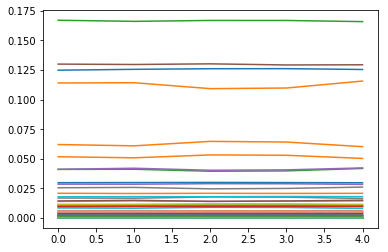

In [71]:
plt.plot([k for k in best_model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()